In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker


def f_interpolate_SST_and_merge(SST_DS, dataset_obs):
    '''function to interpolate SST values on the time resolution of the observations given as input
    input: 
    SST_DS: xarray dataset containing sst values
    dataset_obs: xarray dataset containing the observations to merge with sst data
    output: 
    data_merged: data returned 
    '''
    
    # interpolating sst data at 1 min resolution to the 10 s res of the wind lidar
    sst_data_interp = SST_DS.interp(time=dataset_obs['time'].values)

    # merging the interpolated dataset and the wind lidar dataset
    data_merged = xr.merge([dataset_obs, sst_data_interp])
    return(data_merged)


def f_calculate_binned_data(data_input, SST_binned_arr):
    
    ''' function to calculate mean values of all variables for each SST bin, for all instruments
    author: Claudia Acquistapace
    date: 20 Sept 2021
    input: - data_input: input xarray dataset containing the variables as a function of time, height, to be averaged
            - SST_binned_arr: numpy array of sst binned values for calculating the mean 
    output: dataset_concat: xarray dataset of concatenated values with mean profiles corresponding to the sst bins. A variable n_el counts the number of profiles averaged together
    '''
    # calculating mean quantities f
    dataset_mean = []

    data_input = data_input.load()

    # selecting all columns in the bin interval
    for ind_bin in range(len(SST_binned_arr)-1):

        # selecting slices of datasets columns with SST values in the selected bin
        DS_sliced = data_merged.where((data_input.SST > SST_binned_arr[ind_bin]) & (data_input.SST < SST_binned_arr[ind_bin+1]), drop=True)

        # add variable of the number of elements of the slice
        n_el = len(DS_sliced.SST.values)
        DS_sliced['n_elements'] = n_el

        # calculate mean profile averaging all selected time stamps together
        dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))


    # concatenating datasets corresponding to SST bins on a new bin dimension
    dataset_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
    return(dataset_concat)




dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :16,
    'fontSizeY'    :16,
    'cbarAspect'   :10,
    'fontSizeCbar' :16,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :22, 
    'grid'         :True}




data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/'
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'


In [2]:
# reading tsg file ( data with 1 min resolution)
tsg_data = xr.open_dataset(tsg_file)

# reading data containing flags to filter out rainy columns
flag_file_list = np.sort(glob.glob('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/*_flags_cloud_properties.nc'))
flag_file_list = flag_file_list[13:15]

flag_data = xr.open_mfdataset(flag_file_list)

# reading tsg file ( data with 1 min resolution)
tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)

In [3]:
# building SST binned array
#SST_min = np.nanmin(sst_tsg)
#SST_max = np.nanmax(sst_tsg)
#SST_binned_arr = np.arange(SST_min, SST_max, step=0.025)

SST_binned_arr = np.asarray([26.2 , 26.6 , 26.8 , 27.1 , 27.3 , 27.66])


# calculate label marks for bins
sst_bin_label = []
for ind in range(len(SST_binned_arr)-1):
    sst_bin_label.append(round((SST_binned_arr[ind]+SST_binned_arr[ind+1])/2,2))
    


In [4]:
# reading all arthus data 

# variable list
var_list =['MR']

WVMR_dict = {
     'var_name'  : 'MR',
     'var_string': 'Water vapor mixing ratio',
     'var_units' : ' g kg$^{-1}$',
     'var_min'   : 0.,
     'var_max'   : 30.,
     'thr_min'   : 0.,
     'thr_max'   : 30.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Water vapor mixing ratio: 28/01-04/02'}


dict_list = [WVMR_dict]
#dict_list = [theta_dict, theta_e_dict]


vars_arthus = []

for i_var, dict_var in enumerate(dict_list):

    print('processing variable: ', dict_var['var_string'])
    print(data_path+dict_var['var_name']+'*.nc')
    
    # reading file list of the files for the selected variable
    arthus_file_list = np.sort(glob.glob(data_path+dict_var['var_name']+'_2020*.nc'))
    print(arthus_file_list)
    
    # read the two datasets together
    arthus_dataset = xr.open_mfdataset(arthus_file_list)
    
    # renaming variable time and height and dimension time and height (step necessary for next operations)
    #arthus_dataset = arthus_dataset.rename_dims({'Time':'time'})
    #arthus_dataset = arthus_dataset.rename_dims({'Height':'height'})
    #arthus_dataset = arthus_dataset.rename_vars({'Time':'time'})
    #arthus_dataset = arthus_dataset.rename_vars({'Height':'height'})

    print('files read')

    # interpolate flag on time resolution of arthus data, picking the closest time stamp to lidar time stamps
    flag_data_interp = flag_data.interp(time=arthus_dataset['time'].values, method='nearest')

    print('flag interpolated')
    
    # building a mask to filter out Ze rainy columns and substitute them with nans
    # set to nan the values out of the thresholds for the selected variable
    mask = np.zeros((len(arthus_dataset.time.values), len(arthus_dataset.height.values)))
    for ind in range(len(flag_data_interp.time.values)):
        if (flag_data_interp["flag_rain_ground"].values[ind] == 1) | (flag_data_interp["flag_rain"].values[ind] == 1):
            mask[ind,:] = np.repeat(1, len(arthus_dataset.height.values))

    print('mask calculated')
    
    arthus_dataset["nans"] = xr.full_like(arthus_dataset.product_no_diurnal_cycle, fill_value=np.nan)
    arthus_dataset['product_no_diurnal_cycle'] = xr.where(mask == 0, arthus_dataset['product_no_diurnal_cycle'], arthus_dataset["nans"])

    
    # interpolating SST data on the arthus data 
    arthus_all_SST = f_interpolate_SST_and_merge(SST_DS, arthus_dataset)
    print(arthus_all_SST)
    
    # save arthus data to ncdf for calculating MLQ on all data
    arthus_all_SST.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/arthus_all_MR.nc')
    print('interpolation and merging done')
    strasuka
    # calculating mean quantities for each bin
    dataset_mean = []
    dataset_std = []
    dataset_n = []
    
    # selecting all columns in the bin interval
    for ind_bin in range(len(SST_binned_arr)-1):

        # selecting slices of datasets columns with SST values in the selected bin
        DS_sliced = arthus_all_SST.where((arthus_all_SST.SST > SST_binned_arr[ind_bin]) & (arthus_all_SST.SST < SST_binned_arr[ind_bin+1]), drop=True)
    
        # add variable of the number of elements of the slice
        n_el = len(DS_sliced.SST.values)
        
        # add variable of absolute value of the var
        dims_ds = ['time','height']
        coords_ds = {'time':DS_sliced['time'].values, 'height':DS_sliced['height'].values}
        abs_val = np.abs(DS_sliced['product_no_diurnal_cycle'].values)
        val_no_noise = DS_sliced['product_no_noise'].values
        
        DS_sliced['val_no_noise'] = xr.DataArray(dims=dims_ds, coords=coords_ds, data=val_no_noise)
        DS_sliced['abs_val'] =  xr.DataArray(dims=dims_ds, coords=coords_ds, data=abs_val)

    
        # add variable of count of values for each sliced dataset where we calculate mean/std 
        dims_ds = ['time','height']
        coords_ds = {'time':DS_sliced['time'].values, 'height':DS_sliced['height'].values}
        counts = np.count_nonzero(~np.isnan(DS_sliced['product_no_diurnal_cycle'].values), axis=0)
        #print(np.shape(counts))
        #print(counts)
        DS_sliced['n_elements'] =  xr.DataArray(dims=['height'], \
                                                coords={'height':DS_sliced['height'].values}, \
                                                data=counts, 
                                               attrs={'long_name':'number of values in each bin SST/height'})        
        
        
        # calculate mean profile averaging all selected time stamps together
        dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))
        dataset_std.append(DS_sliced.std(dim='time', skipna=True))
        dataset_n.append(DS_sliced['n_elements'])
        
        
    # concatenating datasets corresponding to SST bins on a new bin dimension
    arthus_SST_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
    arthus_SST_std_concat = xr.concat([dataset_std[i] for i in np.arange(len(dataset_std))], dim='SST_binned')
    arthus_SST_n_concat = xr.concat([dataset_n[i] for i in np.arange(len(dataset_n))], dim='SST_binned')
    
    
    # saving variable of interest in a dictionary with its name: for vertical velocity (VW) we save the absolute value
    # of vertical velocity for mean variable, and the std of the vertical velocity values.
    if dict_var['var_name']!= 'VW':
        dict_variable_nodc = {'var_name':dict_var['var_name'],
                      'var_no_noise':arthus_SST_concat['val_no_noise'].values,
                     'var':arthus_SST_concat['product_no_diurnal_cycle'].values, 
                     'std':arthus_SST_std_concat['product_no_diurnal_cycle'].values,
                      'n':arthus_SST_n_concat.data}
    else:
        dict_variable_nodc = {'var_name':dict_var['var_name'],
                     'var_no_noise':arthus_SST_concat['val_no_noise'].values,
                     'var':arthus_SST_concat['abs_val'].values, 
                     'std':arthus_SST_std_concat['product_no_diurnal_cycle'].values,
                      'n':arthus_SST_n_concat.data}       
    
    
    # append the dictionary in a list of dictionaries containing all arthus variables
    vars_arthus.append(dict_variable_nodc)


# converting the list of dictionaries in a dictionary called variables to be saved in ncdf
dims             = ['sst','height']
coords           = {'sst':SST_binned_arr[0:-1], 'height':arthus_SST_concat['height'].values}
variables = {}
for i in range(len(dict_list)):
    key = vars_arthus[i]['var_name']
    value_no_noise =  xr.DataArray(dims=dims, coords=coords, data=vars_arthus[i]['var_no_noise'],
                             attrs={'long_name':vars_arthus[i]['var_name']+' without noise',
                                    'units':dict_var['var_units']})
    value = xr.DataArray(dims=dims, coords=coords, data=vars_arthus[i]['var'],
                             attrs={'long_name':vars_arthus[i]['var_name']+' without diurnal cycle',
                                    'units':dict_var['var_units']})
    value_std = xr.DataArray(dims=dims, coords=coords, data=vars_arthus[i]['std'],
                             attrs={'long_name':'std of '+vars_arthus[i]['var_name']+' without diurnal cycle',
                                    'units':dict_var['var_units']})
    value_n = xr.DataArray(dims=dims, coords=coords, data=vars_arthus[i]['n'],
                             attrs={'long_name':'number of '+vars_arthus[i]['var_name']+' values in the bin',
                                    'units':'#'})
    variables[key] = value
    variables[key+'_std'] = value_std
    variables[key+'_n'] = value_n
    variables[key+'_no_noise'] = value_no_noise


global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN', 
                        'PI_NAME'          : 'Claudia Acquistapace',
                        'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                        'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                        'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : dict_var['var_string']+'with the diurnal cycle removed from the data',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                        'DATA_GROUP'       : 'Experimental;Profile;Moving',
                        'DATA_SOURCE'      : 'arthus data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                        'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                         'COMMENT'         : 'original data postprocessed by Diego Lange' }
dataset_out    = xr.Dataset(data_vars = variables,
                        coords = coords,
                        attrs = global_attributes)
dataset_out.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/arthus_binned_MR_coarser_sst.nc')

processing variable:  Water vapor mixing ratio
/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/MR*.nc
['/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/MR_20200202.nc'
 '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/MR_20200203.nc']
files read
flag interpolated
mask calculated
<xarray.Dataset>
Dimensions:                   (height: 57, time: 16617)
Coordinates:
  * time                      (time) datetime64[ns] 2020-02-02T00:00:08 ... 2...
  * height                    (height) float32 225.0 275.0 ... 2975.0 3025.0
Data variables:
    product_no_diurnal_cycle  (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    product_no_noise          (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    nans                      (time, height) float64 dask.array<chunksize=(8438, 57), meta=n

NameError: name 'strasuka' is not defined

In [ ]:
print(dataset_out)
# reading humidity profile without noise
q = dataset_out.MR_no_noise.values
np.shape(q)
height = dataset_out.height.values
sst = dataset_out.sst.values

In [18]:
print(dataset_out)
# reading humidity profile without noise
q = dataset_out.MR_no_noise.values
np.shape(q)
height = dataset_out.height.values
sst = dataset_out.sst.values

MLQ_arr_all = np.zeros((np.shape(q)[0]))
for ind in range(np.shape(q)[0]):
    
    ind_h = 0
    # find minimum height where there's a q obs in RS profiles
    while(np.isnan(q[ind,ind_h]) * (ind_h < 3100)):
        ind_h = ind_h+1
    q0 = q[ind,ind_h]
    print(q0)
    
    # find height at which q(z) < q[0]-1
    qo_prof = np.zeros(len(q[ind,:]))
    qo_prof.fill(q0-1.)
    diff = abs(q[ind,:] - qo_prof)

    #print((np.where(el.q.values < q0-1.)[0][0]))
    MLQ_arr_all[ind] = height[np.nanargmin(diff)]
    print(MLQ_arr_all[ind])



15.316087588618997
675.0
14.998766981052766
825.0
15.185235725639876
775.0
13.242379766229682
875.0
13.751688389915694
925.0


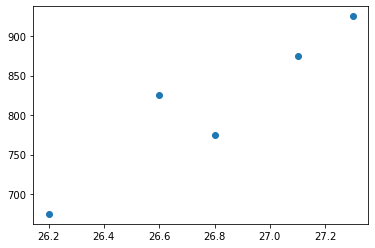

In [20]:
plt.scatter(sst, MLQ_arr_all)

In [5]:
sst


NameError: name 'sst' is not defined